# RELLIS-3D Dataset Exploration
Exploring the [RELLIS-3D dataset](https://github.com/unmannedlab/RELLIS-3D) for VIPR project. This notebook mostly focuses
on image data, the lidar data is too difficult to view in jupyter.

Notes:

- Rellis image dataset contains 3 image datasets which are derived from 5 different videos (mix of jpg and png files)
    - RGB images, label color images, label id images
    - RGB images contain every frame while the label color and id are every EVEN frame
    - Label color are the segemented ground truth images
    - Label ID a grayscale image that maps the pixel value to the class label (sky, tree, mud etc.)
- In this notebook I extracted each folder seperately and renamed them so there would be 3 separate folders
- If extracting all 3 folders (rgb, label color, and label id) in linux they will all be put in the Rellis-3D folder

## Import libraries and define dataset file paths

In [1]:
from IPython.display import display
import os
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

In [2]:
ROOT_DIR = os.getcwd() # notebook directory
RGB_DIR = os.path.join(ROOT_DIR,"../../datasets/rellis/Rellis-3D-rgb")
LABEL_COLOR_DIR = os.path.join(ROOT_DIR,"../../datasets/rellis/Rellis-3D-label-color")
LABEL_ID_DIR = os.path.join(ROOT_DIR,"../../datasets/rellis/Rellis-3D-label-id")
LIDAR_DIR = os.path.join(ROOT_DIR, "../../datasets/rellis/Rellis_3D_os1_cloud_node_color_ply/Rellis-3D") # LIDAR dataset

Check a file path to make sure we are looking in the correct folder

In [3]:
print(os.listdir(RGB_DIR)) # check to see if in correct directory
print(os.listdir(LIDAR_DIR)) # check to see if in correct directory

['00002', '00001', '00003', '00004', '00000']
['00002', '00001', '00004', '00003', '00000']


## Load Images
Displaying the size of each folder about and collect the image file paths to load the images.

In [4]:
def folder_info(directory):
    """Find the number of frames per video in a folder (rgb, label color, label id) 
    and return the file path for each frame. Also return the video id and number frames for plotting
    """
    subdirs = []
    num_files = []
    frame_file_paths = []
    for subdir, dirs, files in os.walk(directory):
        dir_name = subdir.split(os.path.sep)[-1]
        for file in sorted(files):

            image_path = os.path.join(subdir, file)
            if 'ipynb_checkpoints' not in image_path and Path(image_path).stem not in frame_file_paths:
                frame_file_paths.append(image_path)
        if dir_name != '.ipynb_checkpoints'and '.ipynb_checkpoints' not in files:
            subdirs.append(subdir.split(os.path.sep)[-1])
            num_files.append(len(files))
            
    #print("""{0:<21} - Video: {1} has {2:<5} frames, Video: {3} has {4:<5} frames, Video: {5} has {6:<5} frames, 
    #                    Video: {7} has {8:<5} frames, Video: {9} has {10:<5} frames"""
    #                    .format(subdirs[0], subdirs[1], num_files[2], subdirs[3], num_files[4], 
    #                    subdirs[5], num_files[6], subdirs[7], num_files[8], subdirs[9], num_files[10]))

    # Create list of video # and its number of frames, next sort the frames list based on the video # then sort the video # list
    videos = [subdirs[1], subdirs[3], subdirs[5], subdirs[7], subdirs[9]]
    num_frames = [num_files[2], num_files[4], num_files[6], num_files[8], num_files[10]]
    num_frames = [num_frames for _, num_frames in sorted(zip(videos, num_frames))] # sorting based on videos list
    videos = sorted(videos)
    
    return frame_file_paths, videos, num_frames

In [20]:
def bar_subplots(X, y, row_num = 1, col_num = 3, titles = ['RGB', 'Label Color', 'Label ID']):
    """Create multiple bar plots using subplots sharing the same y axis and contain bar labels"""
    # Define plot dimensions and size
    rows = row_num
    cols = col_num
    plot_size = 4
    # Create subplot and loop through the seperate axes
    fig, axes = plt.subplots(rows, cols, figsize=(plot_size * cols, plot_size * rows), sharey=True)
    y_limit = np.amax(X) # get max value in 2D array
    for i in range(rows * cols):
        axes[i].bar(y, X[i])
        axes[i].set_xticks(y) # Specify labels to suppress xticklabel warning
        axes[i].set_xticklabels(y, rotation=30)
        axes[i].set_title(titles[i])
        axes[i].set_ylim([0, y_limit + 1000]) # increase y-axis to max value + 1000
        rects = axes[i].patches
        # Label bars with exact value 
        labels = [f"label{i}" for i in range(len(rects))]
        for rect, label in zip(rects, X[i]):
            height = rect.get_height()
            axes[i].text(
                rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
            )

    fig.text(0.5, -0.01, 'Video Number', ha='center')
    fig.text(-0.01, 0.5, 'Number of Frames', va='center', rotation='vertical')
    fig.suptitle('Number of Frames Per Video',y=1.05)
    fig.tight_layout()

### Number of files per video

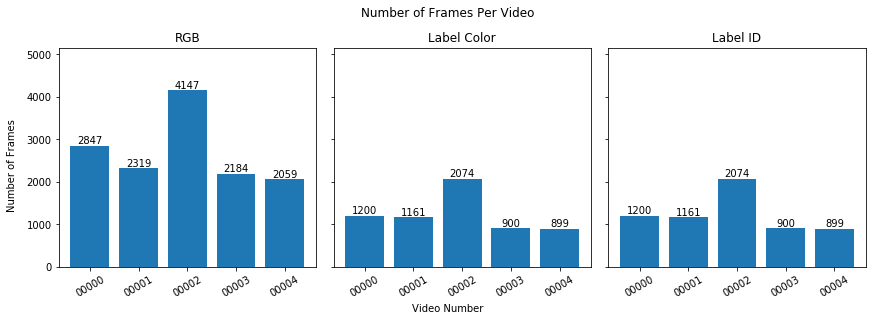

In [21]:
# File paths to each type of frame and number of frames
all_num_frames = []
rgb_frames = []
label_color_frames = []
label_id_frames = []

rgb_frames, video_number, num_frames = folder_info(RGB_DIR)
all_num_frames.append(num_frames)
label_color_frames, video_number, num_frames = folder_info(LABEL_COLOR_DIR)
all_num_frames.append(num_frames)
label_id_frames, video_number, num_frames = folder_info(LABEL_ID_DIR)
all_num_frames.append(num_frames)
bar_subplots(all_num_frames, video_number)

Remove duplicates and frames that do not have a ground truth. Because there are only labels for the even frames, this will probably remove most odd rgb frames. Duplicate names that have a different file extension will not be deleted and must be handled manually, these files will be printed out below.

In [7]:
# Remove duplicates and unique frames (must be in all 3 lists)
rgb_frame_name = [Path(x).stem for x in rgb_frames] # return file name w/o the extension to account for jpg and png files
color_frame_name = [Path(x).stem for x in label_color_frames] 
id_frame_name = [Path(x).stem for x in label_id_frames] 
# Find the frames that appear in all 3 folders
common_frames = list(set(rgb_frame_name).intersection(color_frame_name, id_frame_name))

rgb_dupe_count = Counter(rgb_frame_name)
color_dupe_count = Counter(color_frame_name)
id_dupe_count = Counter(id_frame_name)

# Print duplicate file names w/ different extensions - to hard to handle through code
rgb_dupes = [k for k in rgb_dupe_count if rgb_dupe_count[k] >= 2]
color_dupes = [k for k in color_dupe_count if color_dupe_count[k] >= 2]
id_dupes = [k for k in id_dupe_count if id_dupe_count[k] >= 2]
if len(rgb_dupes) > 0:
    print("Warning: The RGB images contain the following duplicate images, manually delete these: {}".format(rgb_dupes))
if len(color_dupes) > 0:
    print("Warning: The c images contain the following duplicate images, manually delete these: {}".format(color_dupes))
if len(id_dupes) > 0:
    print("Warning: The color id images contain the following duplicate images, manually delete these: \n{}".format(id_dupes))

# Remove frames from image list if they are not shared between all 3 image lists
for frame_file in rgb_frames[:]: # iterating through copy of the list
    frame_file_short = Path(frame_file).stem
    if frame_file_short not in common_frames:
        rgb_frames.remove(frame_file)
for frame_file in label_color_frames[:]:
    frame_file_short = Path(frame_file).stem
    if frame_file_short not in common_frames:
        label_color_frames.remove(frame_file)
for frame_file in label_id_frames[:]: 
    frame_file_short = Path(frame_file).stem
    if frame_file_short not in common_frames:
        label_id_frames.remove(frame_file)

print("{} RGB frames".format(len(rgb_frames)))
print("{} Color frames".format(len(label_color_frames)))
print("{} ID frames".format(len(label_id_frames)))

# Sort final lists - they should already be sorted but for some reason they aren't 
#                   (I think its because the directories on returning in different orders)
rgb_frames = sorted(rgb_frames)
label_color_frames = sorted(label_color_frames)
label_id_frames = sorted(label_id_frames)


6234 RGB frames
6234 Color frames
6234 ID frames


### Display random images from the dataset - RGB, Color, ID

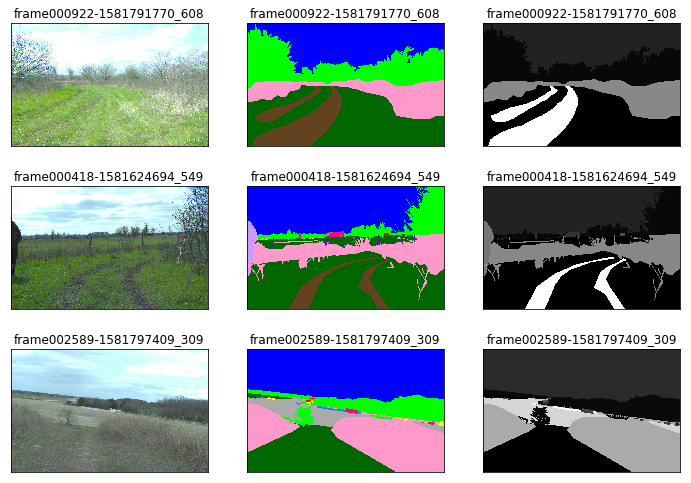

In [8]:
rows = 3
cols = 3
plot_size = 4

image_type_iterable = [rgb_frames, label_color_frames, label_id_frames]
indices = np.random.choice(np.arange(len(rgb_frames)), rows)
indices = np.repeat(indices, cols) # repeat indices to align for 3 images

plt.figure(figsize=(plot_size * cols, plot_size * rows))
for i in range(rows * cols):
    index = indices[i]
    wrap_index = i % len(image_type_iterable) # index used to wrap around the list
    image_data = mpimg.imread(image_type_iterable[wrap_index][index]) 
    #image_data2 = mpimg.imread(label_color_frames[index])
    #image_data3 = mpimg.imread(label_id_frames[0])
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(image_data, cmap="gray")
    plt.title(Path(image_type_iterable[wrap_index][index]).stem)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.subplots_adjust(hspace=-0.5)

### Display segemented image with classes

In [9]:
# Taken from rellis github
color_palette = {
    0: {"color": [0, 0, 0],  "name": "void"},
    1: {"color": [108, 64, 20],   "name": "dirt"},
    3: {"color": [0, 102, 0],   "name": "grass"},
    4: {"color": [0, 255, 0],  "name": "tree"},
    5: {"color": [0, 153, 153],  "name": "pole"},
    6: {"color": [0, 128, 255],  "name": "water"},
    7: {"color": [0, 0, 255],  "name": "sky"},
    8: {"color": [255, 255, 0],  "name": "vehicle"},
    9: {"color": [255, 0, 127],  "name": "object"},
    10: {"color": [64, 64, 64],  "name": "asphalt"},
    12: {"color": [255, 0, 0],  "name": "building"},
    15: {"color": [102, 0, 0],  "name": "log"},
    17: {"color": [204, 153, 255],  "name": "person"},
    18: {"color": [102, 0, 204],  "name": "fence"},
    19: {"color": [255, 153, 204],  "name": "bush"},
    23: {"color": [170, 170, 170],  "name": "concrete"},
    27: {"color": [41, 121, 255],  "name": "barrier"},
    31: {"color": [134, 255, 239],  "name": "puddle"},
    33: {"color": [99, 66, 34],  "name": "mud"},
    34: {"color": [110, 22, 138],  "name": "rubble"}
}

In [10]:
def plot_sample_image(label_array):
    """Plot random label color image with class labels"""
    index = np.random.choice(len(label_array))
    image = mpimg.imread(label_array[index])
    # Convert color palette to list of colors and labels
    colors = [ [value['color'][0] / 255, value['color'][1] / 255, value['color'][2] / 255] 
               for key, value in color_palette.items()]
    labels = [value['name'] for key, value in color_palette.items()]
    
    plt.figure(figsize = (9,9))
    ax = plt.imshow(image)
    plt.title(Path(label_array[index]).stem)
    plt.axis('off')
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=labels[i]) ) for i in range(len(labels)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=2, 
               handleheight=2, handlelength=1.5, labelspacing=1, fontsize='large')

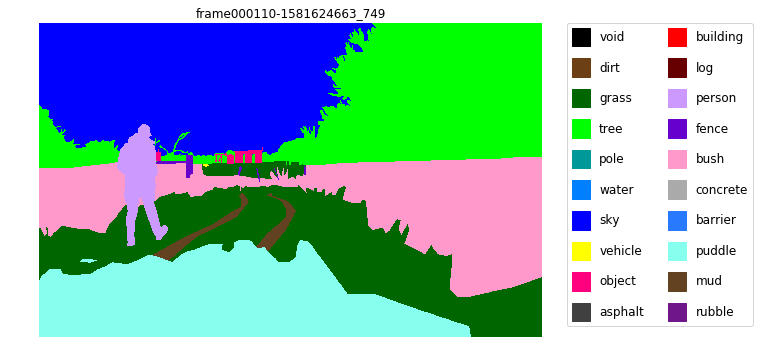

In [11]:
plot_sample_image(label_color_frames)

## Attempting to load all images

In [12]:
def load_images_by_path(frame_path):
    image_list = []
    i = 0
    for image in rgb_frames:
        print(i)
        i += 1
        image_list.append(mpimg.imread(image))
# Jupyter crashes after loading anywhere from 2000-6000 images
#loaded_rgb_images = load_images_by_path()

# LIDAR
Exploring the LiDAR data in this section.

There doesn't seem to be a good solution for veiwing lidar data on the palmetto.

In [13]:
def lidar_info(directory):
    """Find the number of frames per video in a folder (rgb, label color, label id) 
    and return the file path for each frame. Also return the video id and number frames for plotting
    """
    subdirs = []
    num_files = []
    frame_file_paths = []
    for subdir, dirs, files in os.walk(directory):
        dir_name = subdir.split(os.path.sep)[-1]
        for file in sorted(files):

            image_path = os.path.join(subdir, file)
            if 'ipynb_checkpoints' not in image_path and Path(image_path).stem not in frame_file_paths:
                frame_file_paths.append(image_path)
        if dir_name != '.ipynb_checkpoints'and '.ipynb_checkpoints' not in files:
            subdirs.append(subdir.split(os.path.sep)[-1])
            num_files.append(len(files))
            
    #print("""{0:<21} - Video: {1} has {2:<5} frames, Video: {3} has {4:<5} frames, Video: {5} has {6:<5} frames, 
    #                    Video: {7} has {8:<5} frames, Video: {9} has {10:<5} frames"""
    #                    .format(subdirs[0], subdirs[1], num_files[2], subdirs[3], num_files[4], 
    #                    subdirs[5], num_files[6], subdirs[7], num_files[8], subdirs[9], num_files[10]))

    # Create list of video # and its number of frames, next sort the frames list based on the video # then sort the video # list
    videos = [subdirs[1], subdirs[3], subdirs[5], subdirs[7], subdirs[9]]
    num_frames = [num_files[2], num_files[4], num_files[6], num_files[8], num_files[10]]
    num_frames = [num_frames for _, num_frames in sorted(zip(videos, num_frames))] # sorting based on videos list
    videos = sorted(videos)
    
    return frame_file_paths, videos, num_frames

In [14]:
def bar_plot(X, y, row_num = 1, col_num = 3, title = "Lidar Frames Per Video"):
    """Create a single bar plot with bar labels"""
    # Define plot dimensions and size
    rows = row_num
    cols = col_num
    plot_size = 4
    
    fig, ax = plt.subplots(rows, cols, figsize=(plot_size * cols, plot_size * rows), sharey=True)
    
    # Create subplot and loop through the seperate axes
    #fig, axes = plt.plot(rows, cols, figsize=(plot_size * cols, plot_size * rows), sharey=True)
    y_limit = np.amax(X) # get max value in 2D array
    ax.bar(y, X)
    ax.set_xticks(y) # Specify labels to suppress xticklabel warning
    ax.set_xticklabels(y, rotation=30)
    ax.set_title(title)
    ax.set_ylim([0, y_limit + 1000]) # increase y-axis to max value + 1000
    rects = ax.patches
    # Label bars with exact value 
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, X):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )

    fig.text(0.5, -0.01, 'Video Number', ha='center')
    fig.text(-0.01, 0.5, 'Number of Frames', va='center', rotation='vertical')
    #fig.suptitle('Number of Frames Per Video')
    fig.tight_layout()

In [15]:
# File paths to each type of frame and number of frames
all_num_frames = []
lidar_frames = []

lidar_frames, video_number, num_frames = folder_info(LIDAR_DIR)
all_num_frames.append(num_frames)

### Number of files per video

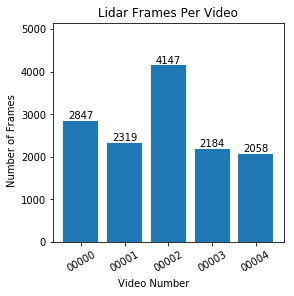

In [16]:
bar_plot(all_num_frames[0], video_number, row_num=1, col_num=1)

In [17]:
# Remove duplicates just in case - assuming they all have .ply extension
print(len(lidar_frames))
lidar_frames = list(set(lidar_frames))
print(len(lidar_frames))

13555
13555


<font size="5"><b>Viewing lidar data in jupyter on the palmetto is too difficult so this will be continued in matlab</b></font>


In [18]:
#import open3d as o3d
#plt.set_loglevel('WARNING') # suppress warning caused by open3d


__Installing open3d on palmetto:__
```bash
pip3 install --ignore-installed PyYAML
pip3 install open3d
```

In [19]:
#index = np.random.choice(len(lidar_frames))
#print(Path(lidar_frames[index]).stem)
#pcd = o3d.io.read_point_cloud(lidar_frames[index]) # Read the point cloud
#mesh = o3d.io.read_triangle_mesh("../../TestData/knot.ply")
#print(pcd)
#o3d.io.write_triangle_mesh("copy_of_knot.ply", mesh)
#o3d.visualization.draw_geometries([pcd]) 
